In [9]:
import os

from fastai.vision.all import *
from fastai.vision import *

import pandas as pd
import PIL

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from src.classification.utils import small_available_models

### Blurry Classification for all classes together

In [5]:
from src.classification.create_balanced_datasets import print_image_distribution
# check the class distribution for each of the classes in the dataset
all_classes_path = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/blurry_classification_datasets/all_classes"
train_path = os.path.join(all_classes_path, 'train')
test_path = os.path.join(all_classes_path, 'test')

print_image_distribution(train_path)
print_image_distribution(test_path)


--- Image Distribution in '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/blurry_classification_datasets/all_classes/train' ---
Class 'good_quality': 1106 images
Class 'blurry': 596 images

--- Image Distribution in '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/blurry_classification_datasets/all_classes/test' ---
Class 'good_quality': 277 images
Class 'blurry': 149 images



In [10]:
resize = Resize(128)

precision_macro_fastai = Precision(average='macro')
recall_macro_fastai = Recall(average='macro')
roc_auc_fastai = RocAuc()

# Custom transform
def custom_transform(size):
    return Resize(size, method="pad", pad_mode="zeros")


class RGB2HSV(Transform):
    def encodes(self, img: PILImage):
        return rgb2hsv(img)
    

item_tfms = custom_transform(size=128)
batch_tfms = [
        RGB2HSV(),
        *aug_transforms(size=128, flip_vert=True, max_rotate=10),
        Brightness(max_lighting=0.2, p=0.75),
        Contrast(max_lighting=0.2, p=0.75),
    ]

In [11]:
import os

# iterate over each dataset in the datasets folder
balanced_datasets = "/home/etaylor/code_projects/thesis/classification_datasets/blur_classification/blur_classification_datasets/all_classes/balanced_datasets"
data_paths = [os.path.join(balanced_datasets, dataset) for dataset in os.listdir(balanced_datasets)]


In [13]:
# TODO: I dont understand why the model preds are not good - check that out.


from fastai.vision.all import *
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import os

# fine tune hyperparameters
epochs = 10
batch_size = 64
lr = 1e-4
# Iterate over each dataset path
results = []
for dataset_path in data_paths:
    print(f"Training on dataset: {os.path.basename(dataset_path)}")
    train_path = os.path.join(dataset_path, "train")
    test_path = os.path.join(dataset_path, "test_balanced")
    
    # Define DataLoaders with a validation split
    dls = ImageDataLoaders.from_folder(
        path=train_path,
        valid_pct=0.2,  # Reserve 20% of training data for validation
        seed=42,        # Ensure reproducibility
        item_tfms=Resize(128),
        bs=batch_size
    )
    
    for model_name, model_fn in small_available_models.items():
        print(f"Training model: {model_name}")
        
        model = vision_learner(
            dls=dls,
            arch=model_fn,
            metrics=[error_rate, precision_macro_fastai, recall_macro_fastai],
        )

        model.fine_tune(epochs=epochs)
        
        # Create the test DataLoader with the same transformations
        test_files = get_image_files(test_path)
        test_dl = dls.test_dl(test_files, with_labels=True)
        # Evaluate on the test set
        preds, targs = model.get_preds(dl=test_dl)
        pred_classes = preds.argmax(dim=1)
        true_classes = targs.numpy()


        precision = precision_score(true_classes, pred_classes, average='micro')
        recall = recall_score(true_classes, pred_classes, average='micro')
        precision_macro = precision_score(true_classes, pred_classes, average='macro')
        recall_macro = recall_score(true_classes, pred_classes, average='macro')
        accuracy = accuracy_score(true_classes, pred_classes)
        conf_matrix = confusion_matrix(true_classes, pred_classes)
        precision_per_class = precision_score(true_classes, pred_classes, average=None)
        recall_per_class = recall_score(true_classes, pred_classes, average=None)

        results.append({
            'dataset': os.path.basename(dataset_path),
            'model': model_name,
            'precision': precision,
            'recall': recall,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
        })
        
        print(f"------ Evaluation Results for model {model_name} ------")
        print(f"Precision Micro: {precision}")
        print(f"Recall Micro: {recall}")
        print(f"Precision Macro: {precision_macro}")
        print(f"Recall Macro: {recall_macro}")
        print(f"Accuracy: {accuracy}")
        print(f"Confusion Matrix:\n{conf_matrix}")
        print(f"Precision per Class: {precision_per_class}")
        print(f"Recall per Class: {recall_per_class}")
        print("\n\n")
        



Training on dataset: train_set_1
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.939081,0.380936,0.156250,0.844116,0.844925,00:00


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.633165,0.347863,0.131250,0.869391,0.867481,00:00
1,0.553798,0.324252,0.143750,0.856078,0.855576,00:00
2,0.484712,0.344468,0.137500,0.869439,0.859023,00:00
3,0.432199,0.418490,0.168750,0.838462,0.827381,00:01
4,0.386278,0.446301,0.143750,0.861740,0.853070,00:00
5,0.334811,0.401728,0.143750,0.861740,0.853070,00:01
6,0.298601,0.420311,0.137500,0.865079,0.860276,00:00
7,0.265710,0.451787,0.150000,0.852381,0.847744,00:00
8,0.233537,0.456909,0.156250,0.846871,0.841165,00:00
9,0.208054,0.456067,0.168750,0.836062,0.828008,00:00


------ Evaluation Results for model alexnet ------
Precision Micro: 0.8188775510204082
Recall Micro: 0.8188775510204082
Precision Macro: 0.8192848020434227
Recall Macro: 0.8188775510204082
Accuracy: 0.8188775510204082
Confusion Matrix:
[[157  39]
 [ 32 164]]
Precision per Class: [0.83068783 0.80788177]
Recall per Class: [0.80102041 0.83673469]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.025088,0.676047,0.256250,0.754741,0.737782,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.673389,0.462624,0.187500,0.814286,0.810150,00:01
1,0.553686,0.499358,0.187500,0.812500,0.813283,00:01
2,0.435356,0.508196,0.187500,0.813321,0.813910,00:01
3,0.350122,0.482126,0.187500,0.812382,0.811404,00:01
4,0.277964,0.542421,0.187500,0.817859,0.808897,00:01
5,0.223020,0.494996,0.150000,0.854220,0.847118,00:01
6,0.177405,0.461632,0.137500,0.863636,0.860902,00:01
7,0.143814,0.480556,0.156250,0.845308,0.841792,00:01
8,0.118827,0.488613,0.162500,0.839683,0.835213,00:01
9,0.097292,0.498805,0.175000,0.830754,0.821429,00:01


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.8086734693877551
Recall Micro: 0.8086734693877551
Precision Macro: 0.8090676883780332
Recall Macro: 0.8086734693877551
Accuracy: 0.8086734693877551
Confusion Matrix:
[[162  34]
 [ 41 155]]
Precision per Class: [0.79802956 0.82010582]
Recall per Class: [0.82653061 0.79081633]



Training model: efficientnet_b0


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.068035,0.899865,0.462500,0.540404,0.540100,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.747651,0.579015,0.237500,0.764706,0.759398,00:01
1,0.606254,0.638853,0.250000,0.750000,0.750627,00:01
2,0.584414,0.620155,0.225000,0.774670,0.773810,00:01
3,0.552800,0.490207,0.181250,0.818431,0.817982,00:01
4,0.532076,0.495603,0.175000,0.825000,0.825815,00:01
5,0.501749,0.505902,0.168750,0.830989,0.831767,00:01
6,0.464340,0.548314,0.181250,0.820138,0.820489,00:01
7,0.430260,0.546864,0.193750,0.805985,0.806704,00:01
8,0.401501,0.530266,0.181250,0.818487,0.819236,00:01
9,0.388152,0.537079,0.193750,0.805985,0.806704,00:01


------ Evaluation Results for model efficientnet_b0 ------
Precision Micro: 0.7602040816326531
Recall Micro: 0.7602040816326531
Precision Macro: 0.7619496855345912
Recall Macro: 0.760204081632653
Accuracy: 0.7602040816326531
Confusion Matrix:
[[157  39]
 [ 55 141]]
Precision per Class: [0.74056604 0.78333333]
Recall per Class: [0.80102041 0.71938776]



Training model: efficientnet_b1


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.915044,0.772233,0.343750,0.661101,0.659461,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.622519,0.681990,0.306250,0.733495,0.703321,00:01
1,0.619837,0.564444,0.275000,0.736622,0.729950,00:01
2,0.576962,0.426373,0.162500,0.837086,0.837719,00:01
3,0.537627,0.447405,0.150000,0.851010,0.848371,00:01
4,0.492605,0.538801,0.193750,0.818265,0.801065,00:01
5,0.447836,0.479120,0.137500,0.865079,0.860276,00:01
6,0.424813,0.457420,0.150000,0.849624,0.849624,00:01
7,0.390988,0.464077,0.156250,0.843529,0.843045,00:01
8,0.358663,0.455015,0.156250,0.845308,0.841792,00:01
9,0.342336,0.453707,0.156250,0.845308,0.841792,00:01


------ Evaluation Results for model efficientnet_b1 ------
Precision Micro: 0.7678571428571429
Recall Micro: 0.7678571428571429
Precision Macro: 0.7681992337164751
Recall Macro: 0.7678571428571428
Accuracy: 0.7678571428571429
Confusion Matrix:
[[154  42]
 [ 49 147]]
Precision per Class: [0.75862069 0.77777778]
Recall per Class: [0.78571429 0.75      ]



Training on dataset: train_set_2
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.936348,0.446437,0.168750,0.841137,0.835526,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.625515,0.418374,0.181250,0.823414,0.821742,00:00
1,0.550756,0.392843,0.162500,0.839599,0.839599,00:00
2,0.477065,0.359408,0.162500,0.837093,0.837093,00:01
3,0.414510,0.353685,0.137500,0.864662,0.864662,00:00
4,0.372702,0.393585,0.168750,0.836010,0.834273,00:00
5,0.332621,0.380468,0.150000,0.850844,0.851504,00:00
6,0.294360,0.363059,0.143750,0.855813,0.856203,00:00
7,0.263073,0.365360,0.143750,0.855813,0.856203,00:00
8,0.230421,0.375691,0.156250,0.843491,0.844298,00:00
9,0.204997,0.377396,0.150000,0.850000,0.850877,00:01


------ Evaluation Results for model alexnet ------
Precision Micro: 0.8188775510204082
Recall Micro: 0.8188775510204082
Precision Macro: 0.8189522743249928
Recall Macro: 0.8188775510204082
Accuracy: 0.8188775510204082
Confusion Matrix:
[[159  37]
 [ 34 162]]
Precision per Class: [0.8238342  0.81407035]
Recall per Class: [0.81122449 0.82653061]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.977573,0.500979,0.225000,0.775253,0.773183,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.646579,0.481153,0.200000,0.800000,0.800752,00:01
1,0.572188,0.448632,0.175000,0.825000,0.825815,00:01
2,0.424859,0.380536,0.143750,0.857691,0.858083,00:01
3,0.334753,0.535544,0.168750,0.838345,0.834900,00:01
4,0.271661,0.362791,0.112500,0.893939,0.890977,00:01
5,0.218077,0.398089,0.131250,0.876325,0.872494,00:01
6,0.172698,0.380866,0.118750,0.882726,0.883145,00:01
7,0.138396,0.385586,0.118750,0.881622,0.882519,00:01
8,0.116825,0.381428,0.100000,0.899625,0.900376,00:01
9,0.099706,0.383157,0.112500,0.887218,0.887218,00:01


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.8163265306122449
Recall Micro: 0.8163265306122449
Precision Macro: 0.8163594709986463
Recall Macro: 0.8163265306122449
Accuracy: 0.8163265306122449
Confusion Matrix:
[[159  37]
 [ 35 161]]
Precision per Class: [0.81958763 0.81313131]
Recall per Class: [0.81122449 0.82142857]



Training model: efficientnet_b0


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.122575,1.071488,0.500000,0.511905,0.510025,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.720294,0.637882,0.306250,0.693468,0.693922,00:01
1,0.691812,0.562155,0.200000,0.799811,0.798872,00:01
2,0.621123,0.562330,0.206250,0.793225,0.793546,00:01
3,0.585294,0.715106,0.256250,0.749714,0.739035,00:01
4,0.559130,0.709364,0.237500,0.762099,0.761278,00:01
5,0.507857,0.674585,0.206250,0.793483,0.794173,00:01
6,0.482395,0.636760,0.237500,0.761905,0.761905,00:01
7,0.455628,0.627527,0.212500,0.786967,0.786967,00:01
8,0.424456,0.613154,0.218750,0.780707,0.781015,00:01
9,0.402407,0.613317,0.225000,0.774670,0.773810,00:01


------ Evaluation Results for model efficientnet_b0 ------
Precision Micro: 0.7882653061224489
Recall Micro: 0.7882653061224489
Precision Macro: 0.7884530228438957
Recall Macro: 0.7882653061224489
Accuracy: 0.7882653061224489
Confusion Matrix:
[[157  39]
 [ 44 152]]
Precision per Class: [0.78109453 0.79581152]
Recall per Class: [0.80102041 0.7755102 ]



Training model: efficientnet_b1


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.000972,0.965482,0.431250,0.610617,0.581767,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.616406,0.720234,0.268750,0.747750,0.737155,00:01
1,0.618850,0.532560,0.181250,0.819112,0.819862,00:01
2,0.567602,0.556406,0.175000,0.824578,0.825188,00:01
3,0.542229,0.503839,0.150000,0.850844,0.851504,00:01
4,0.512629,0.490467,0.156250,0.843491,0.844298,00:01
5,0.474435,0.468617,0.162500,0.838336,0.838972,00:01
6,0.432124,0.448287,0.125000,0.874687,0.874687,00:01
7,0.419135,0.430905,0.131250,0.868627,0.868108,00:01
8,0.390214,0.433407,0.143750,0.856078,0.855576,00:01
9,0.357790,0.433757,0.150000,0.849624,0.849624,00:01


------ Evaluation Results for model efficientnet_b1 ------
Precision Micro: 0.7780612244897959
Recall Micro: 0.7780612244897959
Precision Macro: 0.778939809374592
Recall Macro: 0.778061224489796
Accuracy: 0.7780612244897959
Confusion Matrix:
[[147  49]
 [ 38 158]]
Precision per Class: [0.79459459 0.76328502]
Recall per Class: [0.75       0.80612245]



Training on dataset: train_set_3
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.934481,0.513127,0.250000,0.757143,0.753759,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.566052,0.461983,0.218750,0.782585,0.782895,00:00
1,0.548542,0.471866,0.225000,0.776942,0.776942,00:00
2,0.503004,0.496835,0.212500,0.795238,0.791353,00:00
3,0.439213,0.464928,0.200000,0.799499,0.799499,00:00
4,0.384961,0.465258,0.193750,0.805742,0.806078,00:01
5,0.337086,0.514759,0.181250,0.821569,0.821115,00:00
6,0.302108,0.491561,0.181250,0.820138,0.820489,00:00
7,0.260922,0.492576,0.193750,0.806610,0.807331,00:01
8,0.237306,0.509502,0.187500,0.813321,0.813910,00:00
9,0.211911,0.508152,0.181250,0.819112,0.819862,00:00


------ Evaluation Results for model alexnet ------
Precision Micro: 0.8392857142857143
Recall Micro: 0.8392857142857143
Precision Macro: 0.8392945464011454
Recall Macro: 0.8392857142857143
Accuracy: 0.8392857142857143
Confusion Matrix:
[[164  32]
 [ 31 165]]
Precision per Class: [0.84102564 0.83756345]
Recall per Class: [0.83673469 0.84183673]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.103831,0.637151,0.293750,0.706045,0.703947,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.602191,0.611138,0.250000,0.749529,0.748747,00:01
1,0.514239,0.694034,0.293750,0.708627,0.708333,00:01
2,0.427364,0.781040,0.243750,0.757550,0.757832,00:01
3,0.334176,0.811542,0.218750,0.783922,0.783521,00:01
4,0.277352,0.812944,0.218750,0.780784,0.780388,00:01
5,0.220610,0.839465,0.237500,0.762099,0.761278,00:01
6,0.178904,0.874103,0.237500,0.762500,0.763158,00:01
7,0.146734,0.892051,0.237500,0.761905,0.761905,00:01
8,0.124717,0.874369,0.237500,0.761905,0.761905,00:01
9,0.105228,0.873041,0.243750,0.755672,0.755952,00:01


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.8341836734693877
Recall Micro: 0.8341836734693877
Precision Macro: 0.834610472541507
Recall Macro: 0.8341836734693877
Accuracy: 0.8341836734693877
Confusion Matrix:
[[167  29]
 [ 36 160]]
Precision per Class: [0.8226601  0.84656085]
Recall per Class: [0.85204082 0.81632653]



Training model: efficientnet_b0


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.051473,0.648905,0.337500,0.661654,0.661654,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.613957,0.608491,0.281250,0.718119,0.718358,00:01
1,0.601735,0.642441,0.218750,0.791770,0.776003,00:01
2,0.570373,0.611125,0.243750,0.756686,0.754073,00:01
3,0.544033,0.629651,0.218750,0.781607,0.782268,00:01
4,0.498035,0.672238,0.206250,0.794108,0.794799,00:01
5,0.489804,0.627738,0.218750,0.780707,0.781015,00:01
6,0.468203,0.638171,0.200000,0.800813,0.801378,00:01
7,0.435701,0.634840,0.206250,0.796471,0.796053,00:01
8,0.421881,0.628066,0.206250,0.795102,0.795426,00:01
9,0.391500,0.627495,0.212500,0.788305,0.788847,00:01


------ Evaluation Results for model efficientnet_b0 ------
Precision Micro: 0.8367346938775511
Recall Micro: 0.8367346938775511
Precision Macro: 0.836875
Recall Macro: 0.8367346938775511
Accuracy: 0.8367346938775511
Confusion Matrix:
[[166  30]
 [ 34 162]]
Precision per Class: [0.83    0.84375]
Recall per Class: [0.84693878 0.82653061]



Training model: efficientnet_b1


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.017201,0.731378,0.418750,0.614010,0.592419,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.681041,0.637132,0.287500,0.729756,0.718672,00:01
1,0.632583,0.714212,0.293750,0.718623,0.711466,00:01
2,0.576265,0.753112,0.293750,0.711742,0.709586,00:01
3,0.524466,0.665624,0.243750,0.757550,0.757832,00:01
4,0.498792,0.681669,0.256250,0.743137,0.742794,00:01
5,0.454721,0.633159,0.200000,0.800505,0.798246,00:01
6,0.419521,0.630759,0.200000,0.799811,0.798872,00:01
7,0.388854,0.612036,0.231250,0.768190,0.768484,00:01
8,0.362513,0.612247,0.237500,0.761905,0.761905,00:01
9,0.349210,0.601922,0.243750,0.755686,0.755326,00:01


------ Evaluation Results for model efficientnet_b1 ------
Precision Micro: 0.7831632653061225
Recall Micro: 0.7831632653061225
Precision Macro: 0.7837615755836702
Recall Macro: 0.7831632653061225
Accuracy: 0.7831632653061225
Confusion Matrix:
[[158  38]
 [ 47 149]]
Precision per Class: [0.77073171 0.79679144]
Recall per Class: [0.80612245 0.76020408]



Training on dataset: train_set_4
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.915901,0.420296,0.200000,0.810742,0.804511,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.668991,0.436047,0.168750,0.848178,0.836779,00:01
1,0.574342,0.439796,0.187500,0.835089,0.818922,00:01
2,0.491364,0.415292,0.175000,0.833333,0.828947,00:00
3,0.438319,0.402928,0.150000,0.858730,0.854010,00:00
4,0.390171,0.421246,0.162500,0.846032,0.841479,00:00
5,0.348582,0.491523,0.168750,0.848178,0.836779,00:00
6,0.307039,0.427460,0.143750,0.861203,0.859336,00:00
7,0.282408,0.420386,0.143750,0.861203,0.859336,00:00
8,0.253345,0.432704,0.150000,0.856061,0.853383,00:00
9,0.235806,0.441333,0.156250,0.851005,0.847431,00:00


------ Evaluation Results for model alexnet ------
Precision Micro: 0.8239795918367347
Recall Micro: 0.8239795918367347
Precision Macro: 0.8241905654971218
Recall Macro: 0.8239795918367347
Accuracy: 0.8239795918367347
Confusion Matrix:
[[159  37]
 [ 32 164]]
Precision per Class: [0.83246073 0.8159204 ]
Recall per Class: [0.81122449 0.83673469]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.951991,0.468646,0.187500,0.812500,0.813283,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.603094,0.534681,0.206250,0.793812,0.792293,00:01
1,0.517474,0.584766,0.231250,0.768479,0.769110,00:01
2,0.421585,0.573122,0.200000,0.799562,0.800125,00:01
3,0.332256,0.601593,0.200000,0.802005,0.802005,00:01
4,0.259873,0.609477,0.212500,0.786967,0.786967,00:01
5,0.207894,0.670443,0.181250,0.818431,0.817982,00:01
6,0.175345,0.648312,0.175000,0.824561,0.824561,00:01
7,0.141541,0.644154,0.162500,0.837086,0.837719,00:01
8,0.118321,0.635352,0.162500,0.837086,0.837719,00:01
9,0.100707,0.631943,0.156250,0.843295,0.843672,00:01


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.8188775510204082
Recall Micro: 0.8188775510204082
Precision Macro: 0.8212946206100664
Recall Macro: 0.8188775510204082
Accuracy: 0.8188775510204082
Confusion Matrix:
[[169  27]
 [ 44 152]]
Precision per Class: [0.79342723 0.84916201]
Recall per Class: [0.8622449 0.7755102]



Training model: efficientnet_b0


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.080105,0.739468,0.306250,0.721051,0.683897,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.646673,0.643069,0.262500,0.737023,0.737469,00:01
1,0.618968,0.703135,0.268750,0.733725,0.733396,00:01
2,0.557044,0.664195,0.206250,0.796471,0.796053,00:01
3,0.494999,0.736618,0.237500,0.765871,0.765038,00:01
4,0.486955,0.691458,0.212500,0.787500,0.788221,00:01
5,0.450704,0.652097,0.218750,0.780707,0.781015,00:01
6,0.406596,0.669629,0.212500,0.787241,0.786341,00:01
7,0.394206,0.689013,0.231250,0.768190,0.768484,00:01
8,0.380180,0.692170,0.237500,0.761905,0.761905,00:01
9,0.369463,0.695697,0.237500,0.762039,0.762531,00:01


------ Evaluation Results for model efficientnet_b0 ------
Precision Micro: 0.7448979591836735
Recall Micro: 0.7448979591836735
Precision Macro: 0.7474747474747474
Recall Macro: 0.7448979591836735
Accuracy: 0.7448979591836735
Confusion Matrix:
[[156  40]
 [ 60 136]]
Precision per Class: [0.72222222 0.77272727]
Recall per Class: [0.79591837 0.69387755]



Training model: efficientnet_b1


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.944350,0.931038,0.425000,0.633520,0.589599,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.617647,0.851405,0.325000,0.714545,0.684837,00:01
1,0.584347,0.597645,0.231250,0.775044,0.772243,00:01
2,0.532020,0.625678,0.237500,0.764411,0.764411,00:01
3,0.495353,0.643137,0.256250,0.749723,0.747180,00:01
4,0.486239,0.714730,0.256250,0.751951,0.747807,00:01
5,0.452820,0.731315,0.250000,0.757143,0.753759,00:01
6,0.416658,0.698183,0.250000,0.751880,0.751880,00:01
7,0.406603,0.671021,0.250000,0.753300,0.752506,00:01
8,0.376616,0.672050,0.256250,0.747835,0.746554,00:01
9,0.351085,0.667629,0.256250,0.746275,0.745927,00:01


------ Evaluation Results for model efficientnet_b1 ------
Precision Micro: 0.7755102040816326
Recall Micro: 0.7755102040816326
Precision Macro: 0.78125
Recall Macro: 0.7755102040816326
Accuracy: 0.7755102040816326
Confusion Matrix:
[[166  30]
 [ 58 138]]
Precision per Class: [0.74107143 0.82142857]
Recall per Class: [0.84693878 0.70408163]



Training on dataset: train_set_5
Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.998635,0.546029,0.200000,0.805556,0.803258,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.642086,0.477580,0.168750,0.836010,0.834273,00:00
1,0.533699,0.475968,0.181250,0.823414,0.821742,00:01
2,0.479201,0.427533,0.175000,0.824578,0.825188,00:00
3,0.429348,0.486619,0.200000,0.803583,0.802632,00:00
4,0.381880,0.415105,0.187500,0.812070,0.812657,00:00
5,0.338790,0.399408,0.150000,0.849593,0.850251,00:00
6,0.301965,0.403350,0.168750,0.831614,0.832393,00:00
7,0.267120,0.427380,0.187500,0.812500,0.813283,00:00
8,0.240880,0.433342,0.181250,0.819112,0.819862,00:01
9,0.223151,0.423578,0.175000,0.825829,0.826441,00:00


------ Evaluation Results for model alexnet ------
Precision Micro: 0.8418367346938775
Recall Micro: 0.8418367346938775
Precision Macro: 0.8421573736321
Recall Macro: 0.8418367346938775
Accuracy: 0.8418367346938775
Confusion Matrix:
[[162  34]
 [ 28 168]]
Precision per Class: [0.85263158 0.83168317]
Recall per Class: [0.82653061 0.85714286]



Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.023804,0.703116,0.293750,0.706045,0.703947,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.592729,0.683968,0.293750,0.705602,0.705827,00:01
1,0.505101,0.639389,0.300000,0.699500,0.699875,00:01
2,0.409058,0.885070,0.250000,0.751880,0.751880,00:01
3,0.323876,0.812739,0.262500,0.737500,0.738095,00:01
4,0.256207,0.758279,0.231250,0.769105,0.769737,00:01
5,0.202496,0.786638,0.231250,0.770425,0.765977,00:01
6,0.161448,0.815490,0.225000,0.777494,0.771930,00:01
7,0.131074,0.799703,0.212500,0.790281,0.784461,00:01
8,0.109296,0.783354,0.212500,0.787879,0.785714,00:01
9,0.091629,0.789692,0.206250,0.794667,0.791667,00:01


------ Evaluation Results for model resnet34 ------
Precision Micro: 0.8392857142857143
Recall Micro: 0.8392857142857143
Precision Macro: 0.8392945464011454
Recall Macro: 0.8392857142857143
Accuracy: 0.8392857142857143
Confusion Matrix:
[[165  31]
 [ 32 164]]
Precision per Class: [0.83756345 0.84102564]
Recall per Class: [0.84183673 0.83673469]



Training model: efficientnet_b0


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.015622,0.885806,0.425000,0.601190,0.585213,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.712477,0.846776,0.375000,0.626566,0.626566,00:01
1,0.630355,0.826085,0.362500,0.639098,0.639098,00:01
2,0.559221,0.812516,0.300000,0.699500,0.699875,00:01
3,0.548624,0.907178,0.331250,0.668065,0.666353,00:01
4,0.531912,0.931233,0.306250,0.693040,0.692043,00:01
5,0.513107,0.808401,0.268750,0.730637,0.730890,00:01
6,0.465136,0.823176,0.281250,0.720510,0.715226,00:01
7,0.433534,0.831738,0.287500,0.713555,0.709273,00:01
8,0.407378,0.845821,0.312500,0.688910,0.683584,00:01
9,0.386925,0.810300,0.281250,0.719462,0.715852,00:01


------ Evaluation Results for model efficientnet_b0 ------
Precision Micro: 0.7780612244897959
Recall Micro: 0.7780612244897959
Precision Macro: 0.7780684628400365
Recall Macro: 0.778061224489796
Accuracy: 0.7780612244897959
Confusion Matrix:
[[153  43]
 [ 44 152]]
Precision per Class: [0.77664975 0.77948718]
Recall per Class: [0.78061224 0.7755102 ]



Training model: efficientnet_b1


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,1.019754,0.759854,0.393750,0.649871,0.618108,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,time
0,0.678501,0.545896,0.243750,0.757550,0.757832,00:01
1,0.624655,0.659021,0.275000,0.729798,0.728070,00:01
2,0.570799,0.783368,0.262500,0.736958,0.736216,00:01
3,0.513614,0.758382,0.262500,0.736842,0.736842,00:01
4,0.475735,0.793166,0.293750,0.706721,0.703321,00:01
5,0.435128,0.848572,0.275000,0.727595,0.721178,00:01
6,0.406848,0.776468,0.256250,0.744026,0.741541,00:01
7,0.373194,0.781388,0.256250,0.743426,0.742168,00:01
8,0.349947,0.777774,0.250000,0.749529,0.748747,00:01
9,0.338902,0.790763,0.250000,0.749529,0.748747,00:01


------ Evaluation Results for model efficientnet_b1 ------
Precision Micro: 0.7653061224489796
Recall Micro: 0.7653061224489796
Precision Macro: 0.7657488527325824
Recall Macro: 0.7653061224489797
Accuracy: 0.7653061224489796
Confusion Matrix:
[[146  50]
 [ 42 154]]
Precision per Class: [0.77659574 0.75490196]
Recall per Class: [0.74489796 0.78571429]





In [14]:
results_df = pd.DataFrame(results)
results_df.head()

,dataset,model,precision,recall,precision_macro,recall_macro,precision_per_class,recall_per_class,accuracy,confusion_matrix
0,train_set_1,alexnet,0.818878,0.818878,0.819285,0.818878,"[0.8306878306878307, 0.8078817733990148]","[0.8010204081632653, 0.8367346938775511]",0.818878,"[[157, 39], [32, 164]]"
1,train_set_1,resnet34,0.808673,0.808673,0.809068,0.808673,"[0.7980295566502463, 0.8201058201058201]","[0.826530612244898, 0.7908163265306123]",0.808673,"[[162, 34], [41, 155]]"
2,train_set_1,efficientnet_b0,0.760204,0.760204,0.761950,0.760204,"[0.7405660377358491, 0.7833333333333333]","[0.8010204081632653, 0.7193877551020408]",0.760204,"[[157, 39], [55, 141]]"
3,train_set_1,efficientnet_b1,0.767857,0.767857,0.768199,0.767857,"[0.7586206896551724, 0.7777777777777778]","[0.7857142857142857, 0.75]",0.767857,"[[154, 42], [49, 147]]"
4,train_set_2,alexnet,0.818878,0.818878,0.818952,0.818878,"[0.8238341968911918, 0.8140703517587939]","[0.8112244897959183, 0.826530612244898]",0.818878,"[[159, 37], [34, 162]]"


In [15]:
results_csv_path = "/home/etaylor/code_projects/thesis/src/classification/notebooks/blur_classification/evaluation_results/fastai_classification_small models_to_datasets.csv"
average_results_csv_path = "/home/etaylor/code_projects/thesis/src/classification/notebooks/blur_classification/evaluation_results/fastai_classification_small models_to_datasets_average_results.csv"

In [16]:
results_df.to_csv(results_csv_path, index=False)

For Loading the results without running the code again use the code below

In [ ]:
results_df = pd.read_csv(results_csv_path)
results_df.head()

In [17]:
import numpy as np
# create an average result dataframe for each of the models
average_results = []

for model_name in results_df['model'].unique():
    model_results = results_df[results_df['model'] == model_name]
    
    average_results.append({
        'model': model_name,
        'precision': model_results['precision'].mean(),
        'recall': model_results['recall'].mean(),
        'precision_macro': model_results['precision_macro'].mean(),
        'recall_macro': model_results['recall_macro'].mean(),
        'accuracy': model_results['accuracy'].mean(),
        'precision_per_class': model_results['precision_per_class'].mean(axis=0),
        'recall_per_class': model_results['recall_per_class'].mean(axis=0),
        'confusion_matrix': model_results['confusion_matrix'].mean(axis=0),
    })
average_results_df = pd.DataFrame(average_results)
average_results_df.head()

,model,precision,recall,precision_macro,recall_macro,accuracy,precision_per_class,recall_per_class,confusion_matrix
0,alexnet,0.828571,0.828571,0.828776,0.828571,0.828571,"[0.8361279961072651, 0.8214238286522481]","[0.8173469387755101, 0.8397959183673469]","[[160.2, 35.8], [31.4, 164.6]]"
1,resnet34,0.823469,0.823469,0.824125,0.823469,0.823469,"[0.8142535931723982, 0.833997126399361]","[0.8387755102040817, 0.8081632653061226]","[[164.4, 31.6], [37.6, 158.4]]"
2,efficientnet_b0,0.781633,0.781633,0.782564,0.781633,0.781633,"[0.7701065067028298, 0.7950218607744786]","[0.8051020408163266, 0.7581632653061223]","[[157.8, 38.2], [47.4, 148.6]]"
3,efficientnet_b1,0.773980,0.773980,0.775580,0.773980,0.773980,"[0.7683228329638241, 0.7828369555991038]","[0.786734693877551, 0.7612244897959183]","[[154.2, 41.8], [46.8, 149.2]]"


In [18]:
average_results_df.to_csv(average_results_csv_path, index=False)

In [ ]:
# Load the average results
average_results_df = pd.read_csv(average_results_csv_path)
average_results_df.head()

### Plot the evaluation results

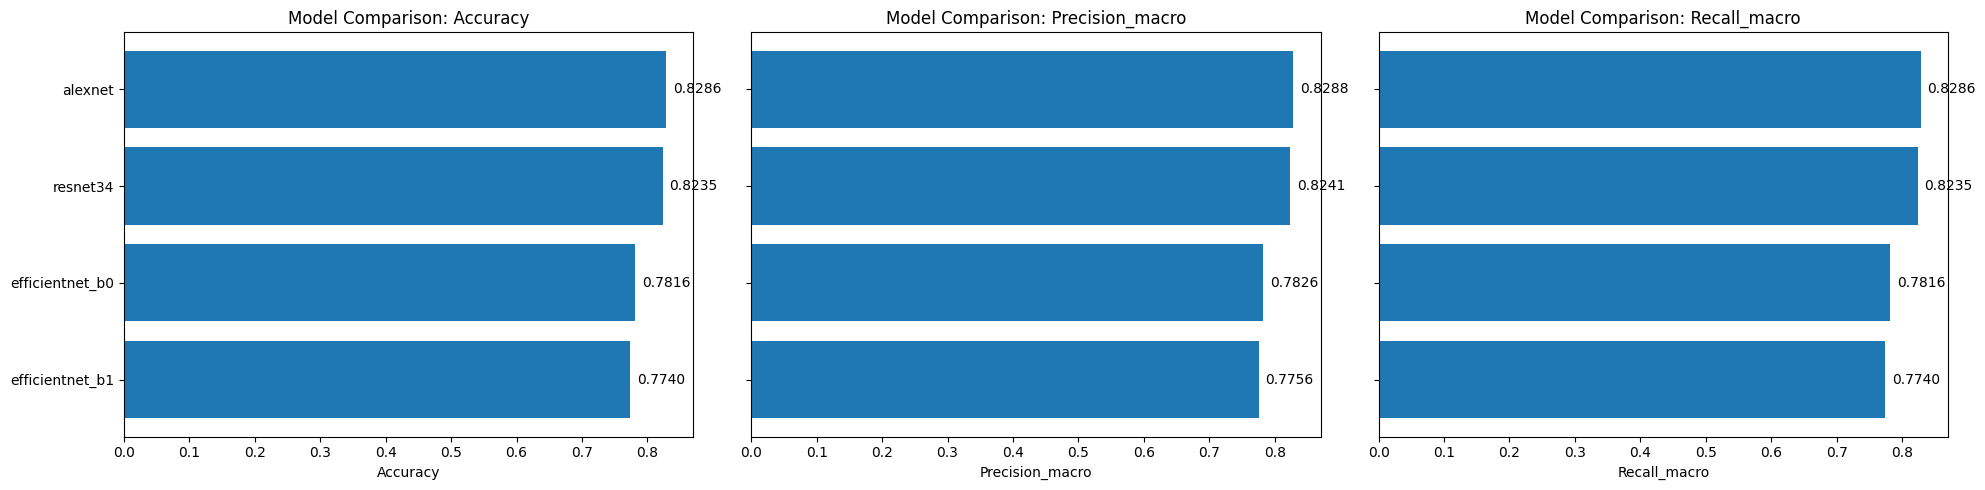

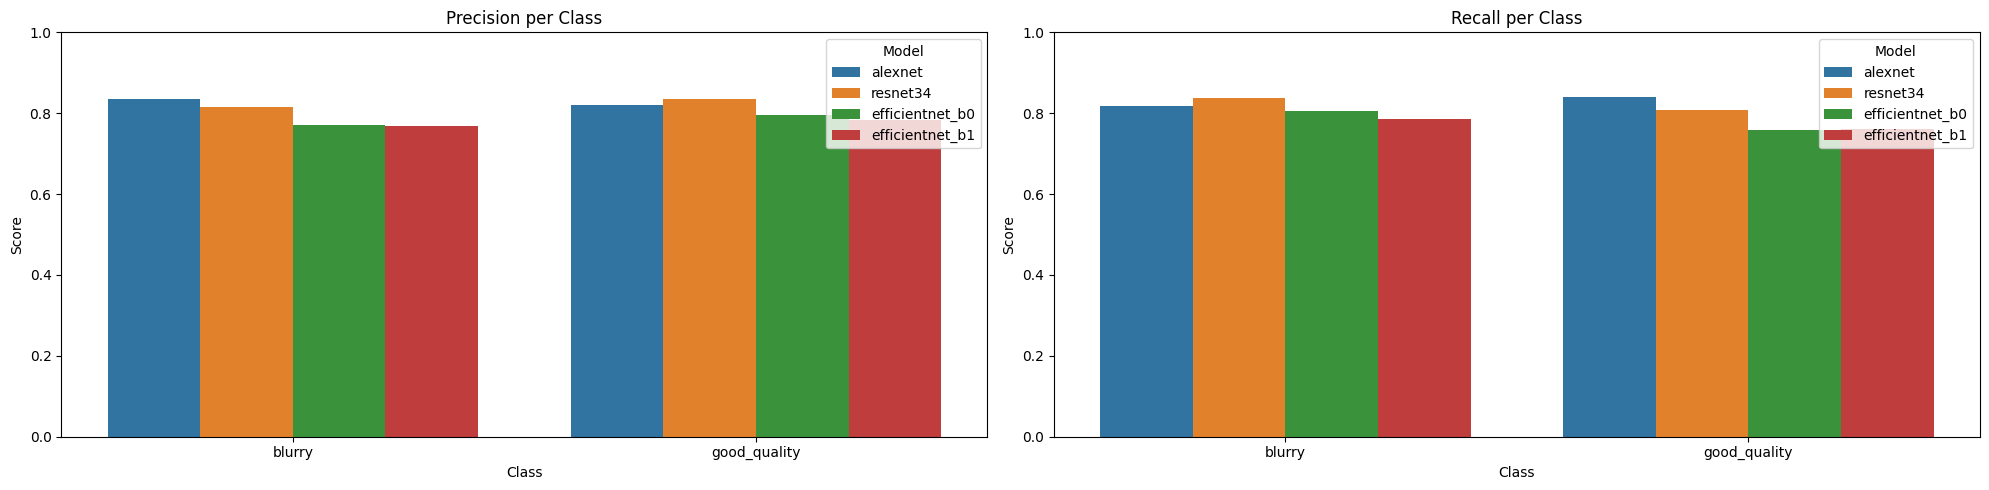

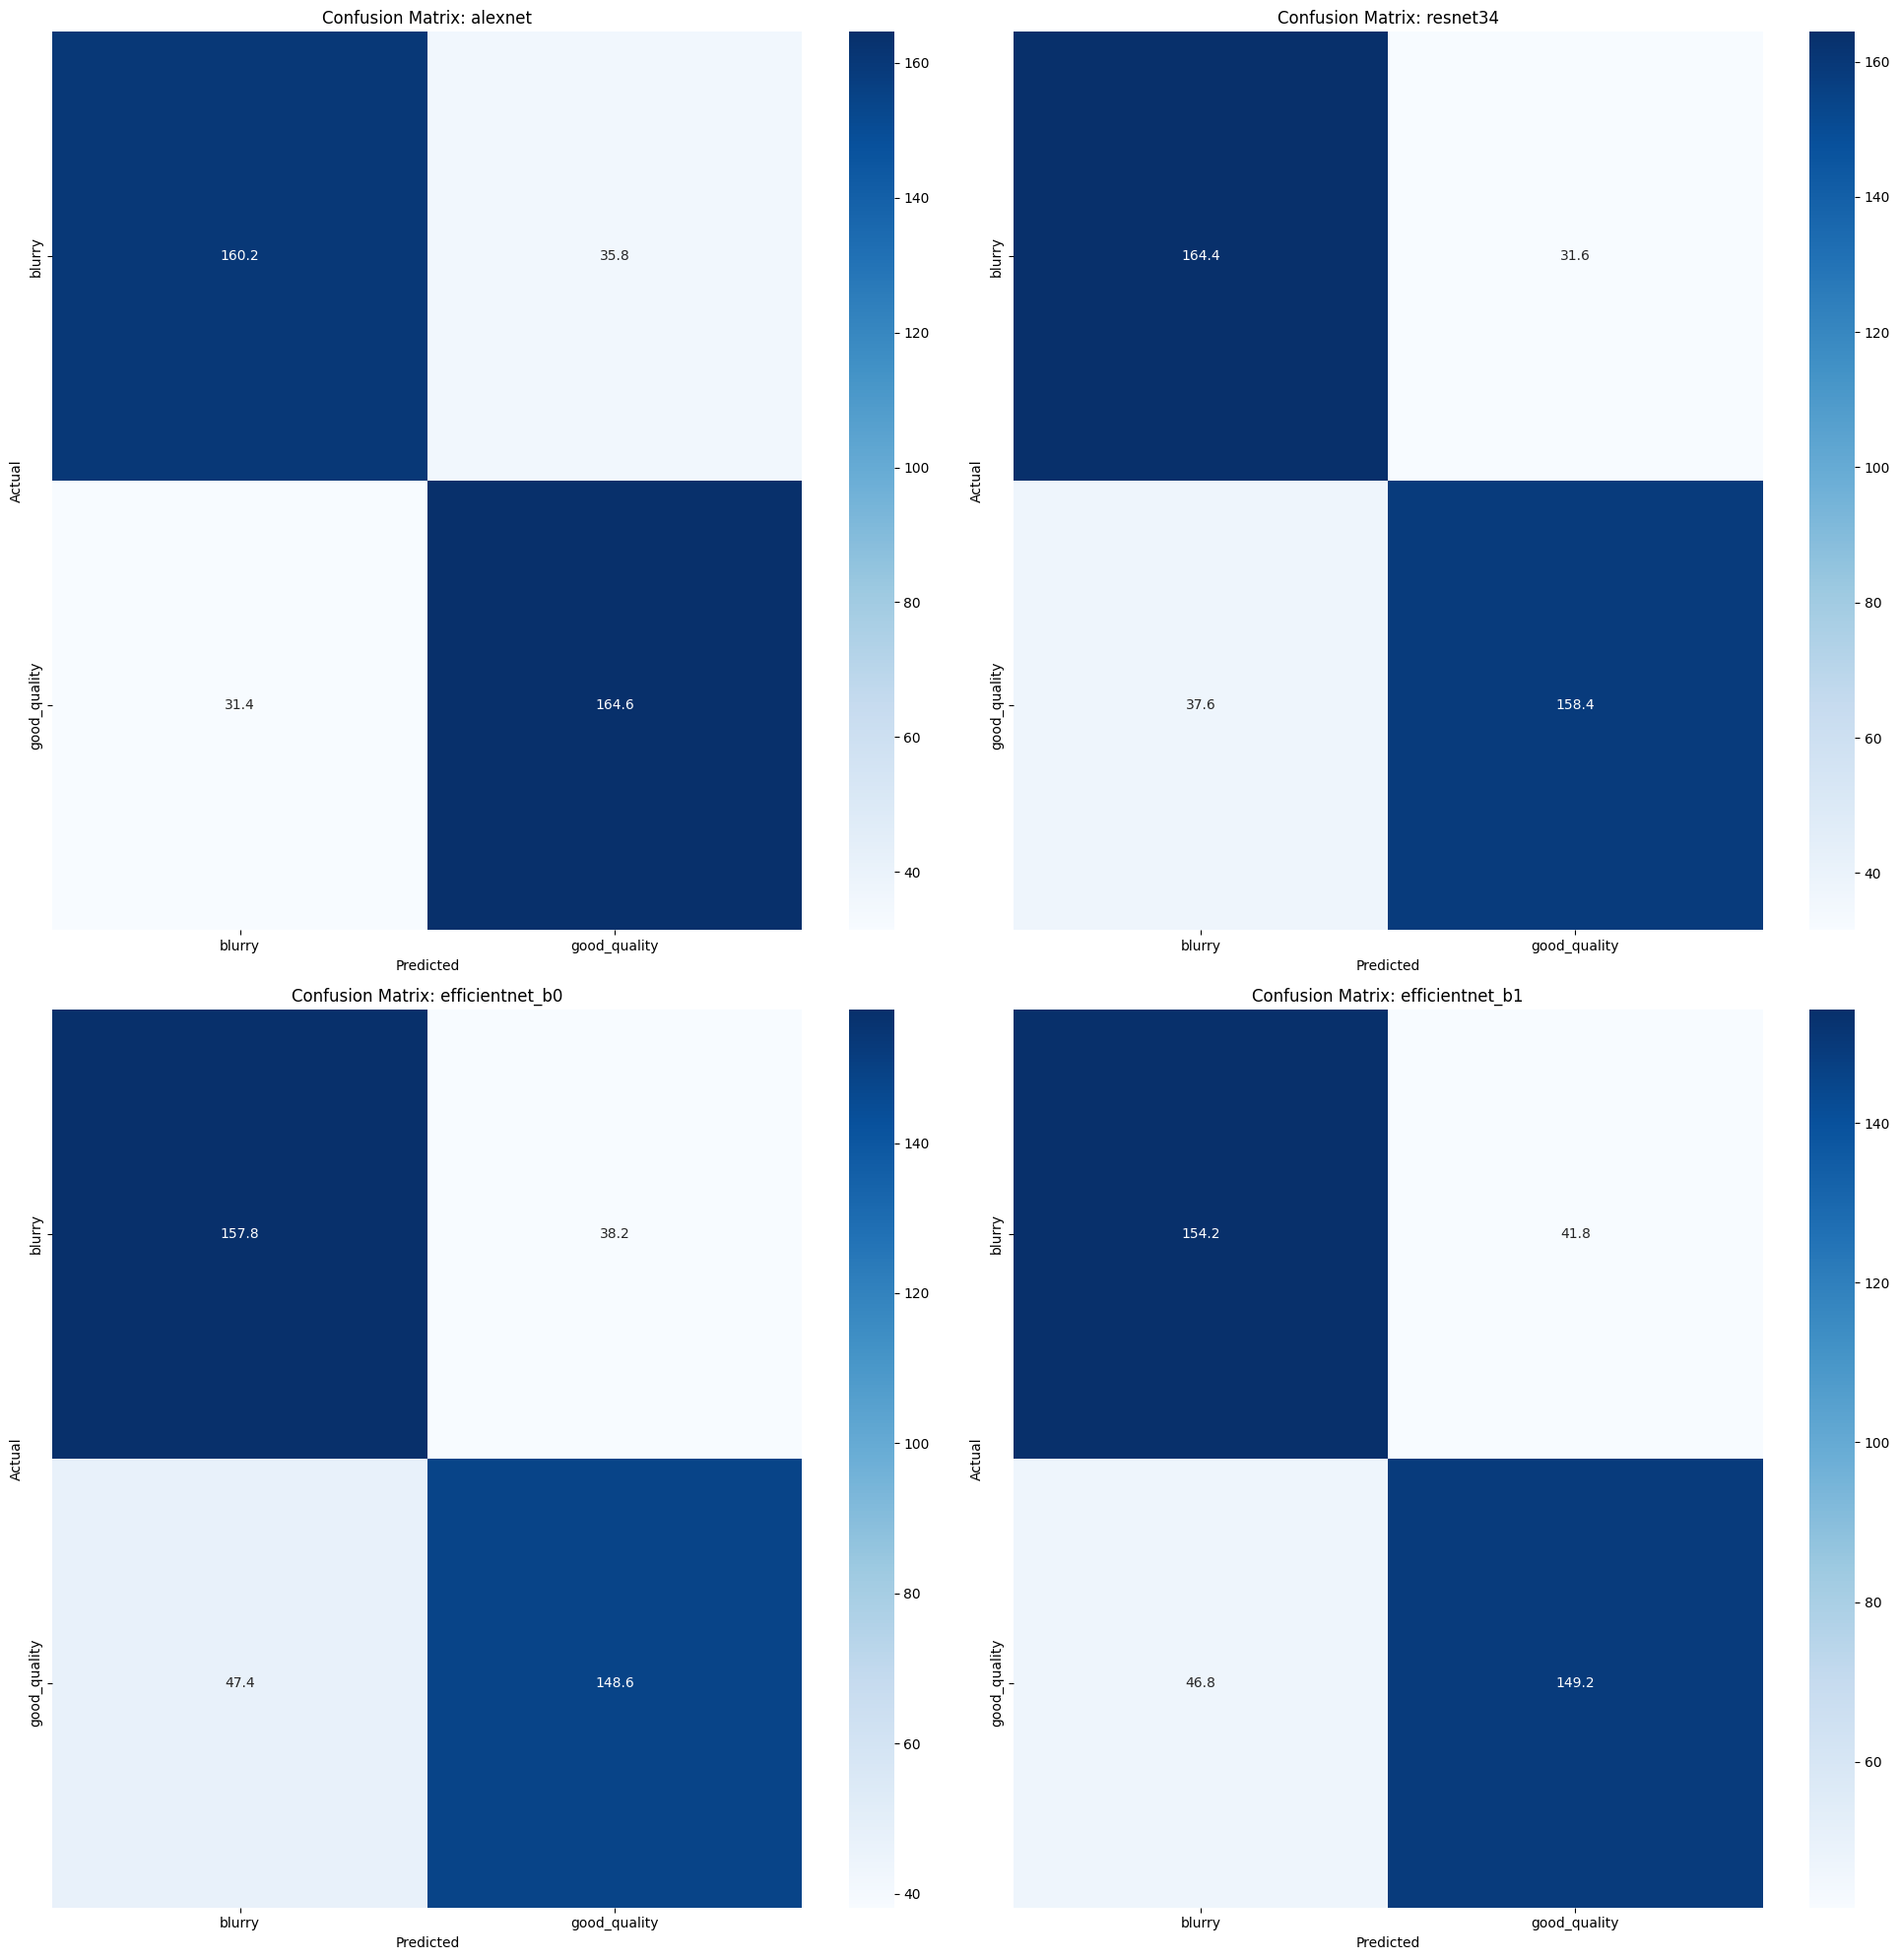

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Plotting metrics for each model
metrics_to_plot = ["accuracy", "precision_macro", "recall_macro"]
num_metrics = len(metrics_to_plot)
fig, axes = plt.subplots(1, num_metrics, figsize=(20, 5), sharey=True)

for i, metric in enumerate(metrics_to_plot):
    metric_values = average_results_df[metric]
    models = average_results_df['model']
    y_pos = np.arange(len(models))

    axes[i].barh(y_pos, metric_values, align='center')
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(models)
    axes[i].invert_yaxis()
    axes[i].set_xlabel(metric.capitalize())
    axes[i].set_title(f'Model Comparison: {metric.capitalize()}')

    for j in range(len(models)):
        axes[i].text(metric_values[j] + 0.01, y_pos[j], f'{metric_values[j]:.4f}', va='center')

plt.tight_layout()
plt.show()

# Plot precision and recall for each class
class_labels = ['blurry', 'good_quality']

# Prepare precision and recall data for plotting
precision_data = []
recall_data = []
for i, row in average_results_df.iterrows():
    model_name = row['model']
    precision_per_class = row['precision_per_class']
    recall_per_class = row['recall_per_class']
    for j, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
        precision_data.append({'Model': model_name, 'Class': class_labels[j], 'Score': precision})
        recall_data.append({'Model': model_name, 'Class': class_labels[j], 'Score': recall})

precision_df = pd.DataFrame(precision_data)
recall_df = pd.DataFrame(recall_data)

# Plot class-wise precision and recall
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(x='Class', y='Score', hue='Model', data=precision_df, ax=axes[0])
axes[0].set_title('Precision per Class')
axes[0].set_ylim(0, 1)

sns.barplot(x='Class', y='Score', hue='Model', data=recall_df, ax=axes[1])
axes[1].set_title('Recall per Class')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Plot confusion matrices for each model
num_models = len(average_results_df)
num_cols = 2
num_rows = (num_models + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
axes = axes.flatten()

for i, (index, row) in enumerate(average_results_df.iterrows()):
    cm = np.array(row['confusion_matrix'])
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=axes[i],
                xticklabels=class_labels, yticklabels=class_labels)
    axes[i].set_title(f'Confusion Matrix: {row["model"]}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()